In [ ]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap

import warnings
warnings.filterwarnings("ignore")

In [ ]:
fname = '../data/dry_eye_disease_parsed.csv'
df0 = pd.read_csv(fname)

%run '../data/utils.py'
%run '../data/features_list.py'
%run '../data/model_params.py'

In [31]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition', 'height', 'weight']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition', 'bmi']


In [32]:
random_state = 1205
models = {
    "XG Boost Classifier" : XGBClassifier(objective='reg:squarederror', random_state=random_state),
    "Random Forest Classifier": RandomForestClassifier(random_state=random_state),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=random_state),
    "AdaBoost Classifier": AdaBoostClassifier(random_state=random_state),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=random_state),
    "Logistic Regression": LogisticRegression(random_state=random_state),
    "Support Vector Classifier (SVC)": SVC(random_state=random_state),
    "Nu-Support Vector Classifier": NuSVC(random_state=random_state),
    "Linear SVC": LinearSVC(random_state=random_state)
}

Model: XG Boost Classifier
Accuracy: 65.25%, 64.47%
Precision: 62.56%, 61.59%
Recall: 65.25%, 64.47%
F1 Score: 62.51%, 61.95%
------------------------------
Model: Random Forest Classifier
Accuracy: 69.47%, 69.34%
Precision: 68.85%, 68.05%
Recall: 69.47%, 69.34%
F1 Score: 64.59%, 64.34%
------------------------------
Model: Decision Tree Classifier
Accuracy: 56.40%, 55.50%
Precision: 57.11%, 56.64%
Recall: 56.40%, 55.50%
F1 Score: 56.72%, 56.00%
------------------------------
Model: AdaBoost Classifier
Accuracy: 69.75%, 69.22%
Precision: 69.79%, 68.06%
Recall: 69.75%, 69.22%
F1 Score: 64.45%, 63.84%
------------------------------
Model: Gradient Boosting Classifier
Accuracy: 69.95%, 69.81%
Precision: 69.68%, 68.83%
Recall: 69.95%, 69.81%
F1 Score: 65.13%, 64.95%
------------------------------
Model: Logistic Regression
Accuracy: 68.75%, 69.00%
Precision: 68.78%, 68.36%
Recall: 68.75%, 69.00%
F1 Score: 62.39%, 62.68%
------------------------------
Model: Support Vector Classifier (SVC)


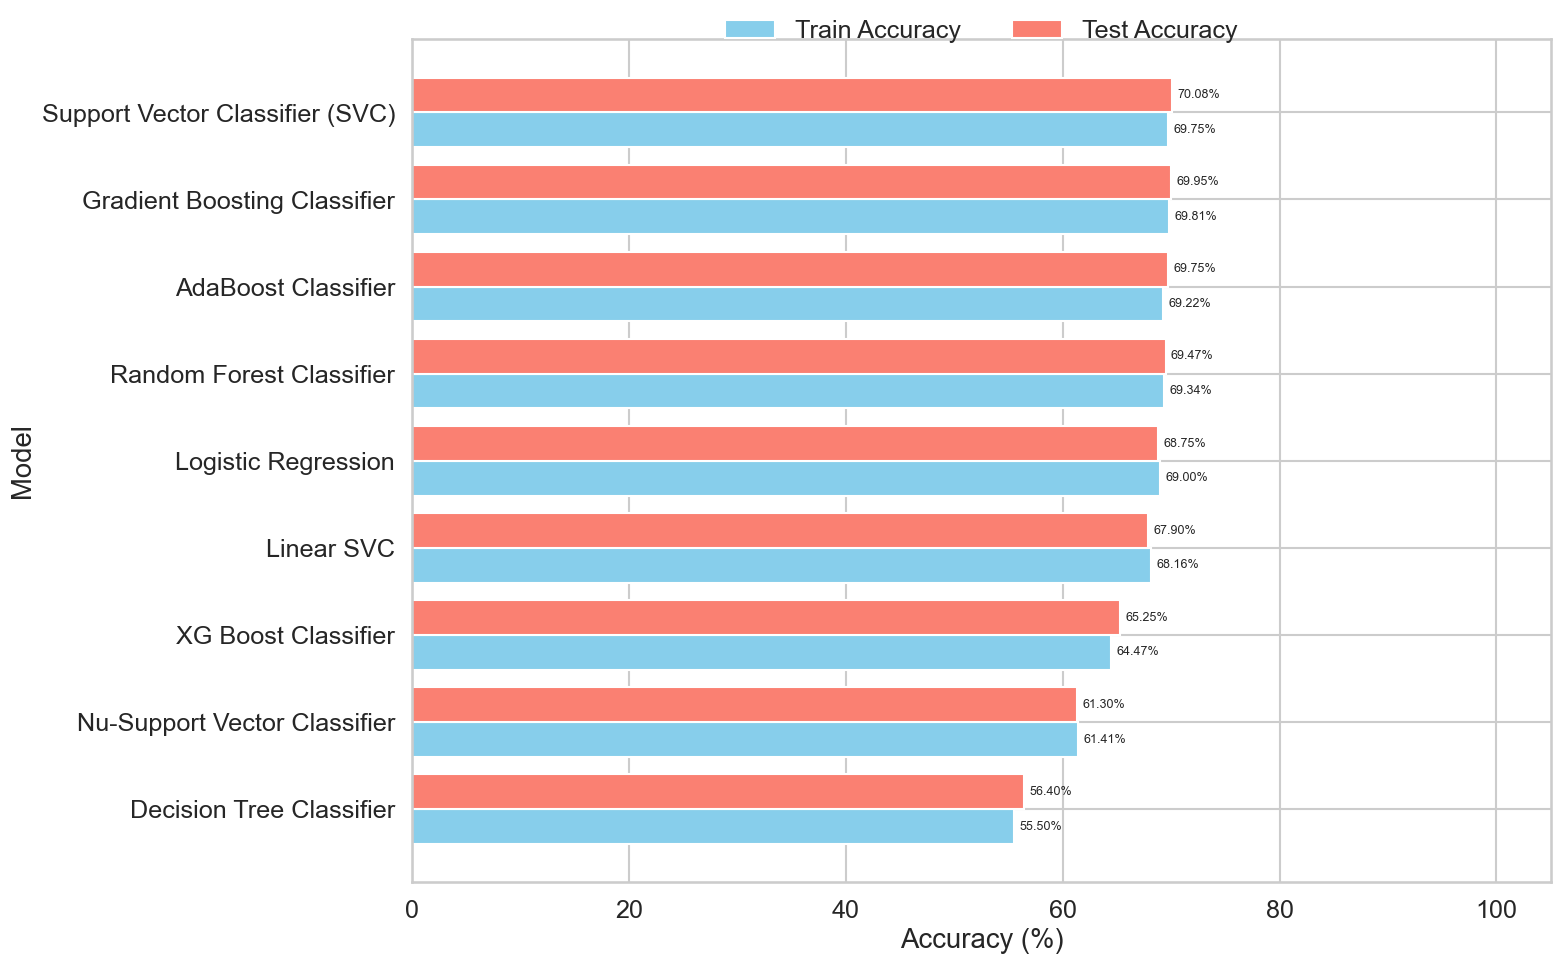

In [33]:
x=df.drop(['dry_eye_disease'],axis=1)
y=df['dry_eye_disease']

x_train_init,x_test,y_train_init,y_test=train_test_split(x,y,test_size=0.2,random_state=random_state)
x_train,x_val,y_train,y_val=train_test_split(x_train_init,y_train_init,test_size=0.2,random_state=random_state)
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)
x_val=ss.transform(x_val)

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

metrics0 = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = model.predict(x_val)
    acc0 = accuracy_score(y_val, y_pred0)
    f10 = f1_score(y_val, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_val, y_pred0, average='weighted')
    precision0 = precision_score(y_val, y_pred0, average='weighted')

    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc * 100)
    metrics['Precision'].append(precision * 100)
    metrics['Recall'].append(recall * 100)
    metrics['F1 Score'].append(f1 * 100)
    
    metrics0['Model'].append(name)
    metrics0['Accuracy'].append(acc0 * 100)
    metrics0['Precision'].append(precision0 * 100)
    metrics0['Recall'].append(recall0 * 100)
    metrics0['F1 Score'].append(f10 * 100)

    print(f"Model: {name}")
    print(f"Accuracy: {acc * 100:.2f}%, {acc0 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%, {precision0 * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%, {recall0 * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%, {f10 * 100:.2f}%")
    print("-" * 30)
    

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics0 = pd.DataFrame(metrics0)

# Merge train and test metrics for plotting
df_plot = df_metrics.merge(df_metrics0, on="Model", suffixes=("_Test", "_Train"))

# Sort by test accuracy
df_plot = df_plot.sort_values(by="Accuracy_Test", ascending=True).reset_index(drop=True)


# Set up the plot
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Bar positions
y_pos = range(len(df_plot))
bar_width = 0.4

# Plot train accuracy (shifted left)
plt.barh(
    [i - bar_width/2 for i in y_pos],
    df_plot["Accuracy_Train"],
    height=bar_width,
    label="Train Accuracy",
    color="skyblue"
)

# Plot test accuracy (shifted right)
plt.barh(
    [i + bar_width/2 for i in y_pos],
    df_plot["Accuracy_Test"],
    height=bar_width,
    label="Test Accuracy",
    color="salmon"
)

# Y-axis labels
plt.yticks(y_pos, df_plot["Model"])

# Add values to bars
for i, (train_acc, test_acc) in enumerate(zip(df_plot["Accuracy_Train"], df_plot["Accuracy_Test"])):
    plt.text(train_acc + 0.5, i - bar_width/2, f"{train_acc:.2f}%", va="center", fontsize=9)
    plt.text(test_acc + 0.5, i + bar_width/2, f"{test_acc:.2f}%", va="center", fontsize=9)

# Labels and title
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.xlim(0, 105)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

Model: XG Boost Classifier
Accuracy: 51.20%, 50.91%
Precision: 50.95%, 50.69%
Recall: 51.20%, 50.91%
F1 Score: 50.98%, 50.74%
------------------------------
Model: Random Forest Classifier
Accuracy: 51.10%, 50.91%
Precision: 50.03%, 49.82%
Recall: 51.10%, 50.91%
F1 Score: 49.07%, 49.06%
------------------------------
Model: Decision Tree Classifier
Accuracy: 50.95%, 50.62%
Precision: 50.90%, 50.62%
Recall: 50.95%, 50.62%
F1 Score: 50.92%, 50.62%
------------------------------
Model: AdaBoost Classifier
Accuracy: 52.30%, 53.09%
Precision: 49.37%, 51.42%
Recall: 52.30%, 53.09%
F1 Score: 42.13%, 43.11%
------------------------------
Model: Gradient Boosting Classifier
Accuracy: 51.80%, 52.03%
Precision: 50.00%, 50.15%
Recall: 51.80%, 52.03%
F1 Score: 46.59%, 46.54%
------------------------------
Model: Logistic Regression
Accuracy: 52.73%, 52.69%
Precision: 48.24%, 46.49%
Recall: 52.73%, 52.69%
F1 Score: 38.55%, 38.43%
------------------------------
Model: Support Vector Classifier (SVC)


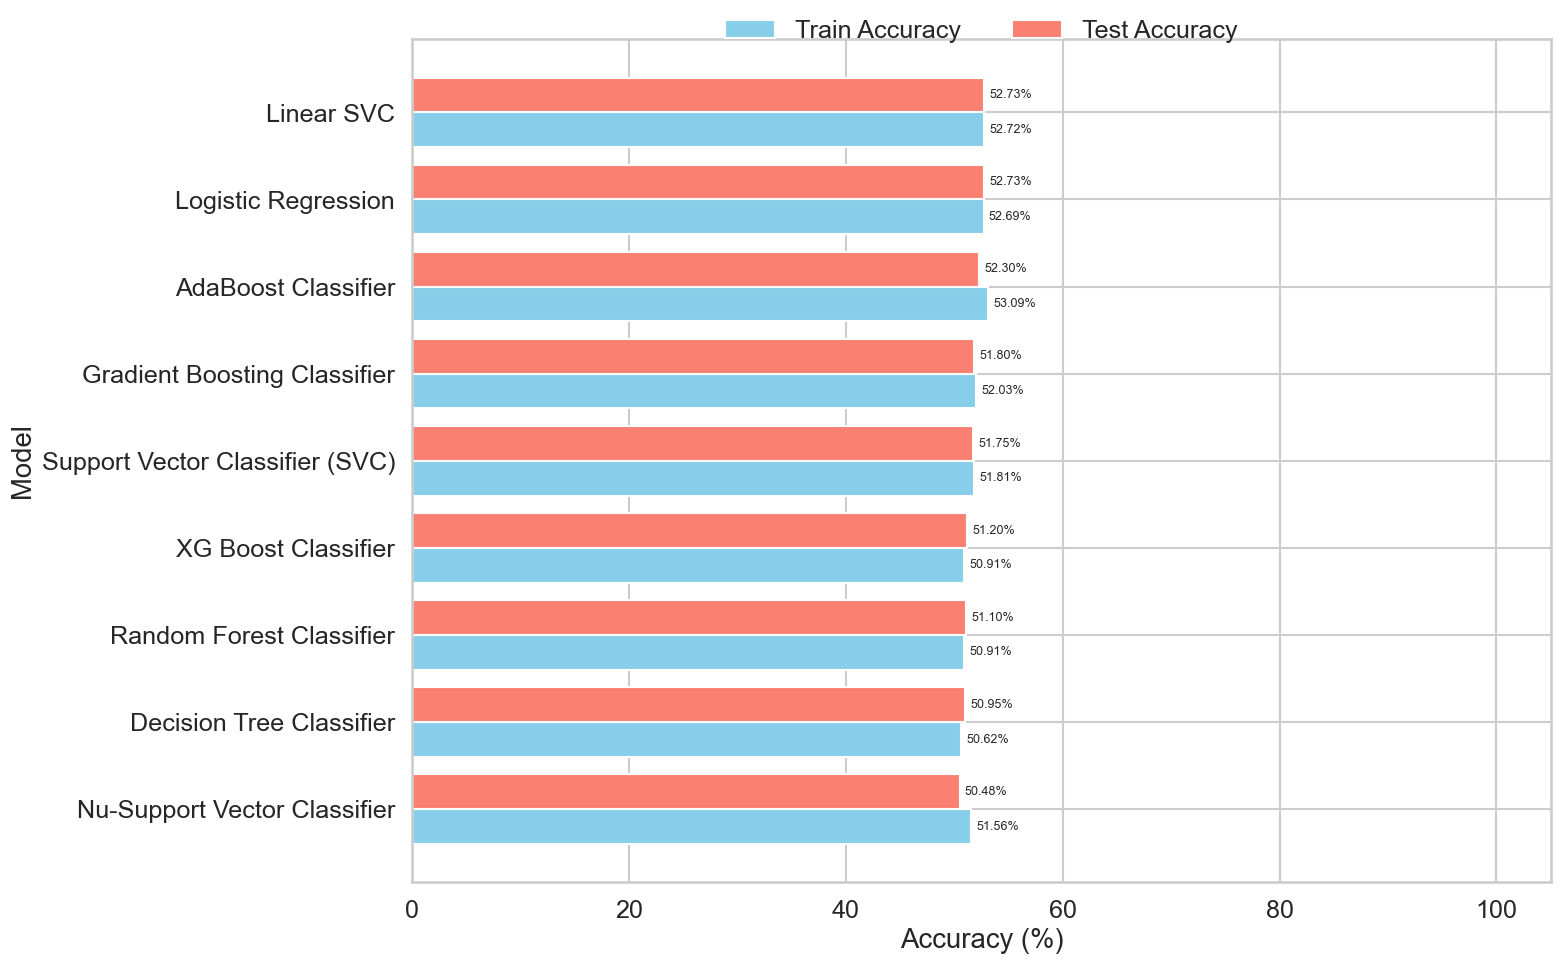

In [34]:
x=df.drop(['insomnia'],axis=1)
y=df['insomnia']

x_train_init,x_test,y_train_init,y_test=train_test_split(x,y,test_size=0.2,random_state=random_state)
x_train,x_val,y_train,y_val=train_test_split(x_train_init,y_train_init,test_size=0.2,random_state=random_state)
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)
x_val=ss.transform(x_val)

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

metrics0 = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = model.predict(x_val)
    acc0 = accuracy_score(y_val, y_pred0)
    f10 = f1_score(y_val, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_val, y_pred0, average='weighted')
    precision0 = precision_score(y_val, y_pred0, average='weighted')

    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc * 100)
    metrics['Precision'].append(precision * 100)
    metrics['Recall'].append(recall * 100)
    metrics['F1 Score'].append(f1 * 100)
    
    metrics0['Model'].append(name)
    metrics0['Accuracy'].append(acc0 * 100)
    metrics0['Precision'].append(precision0 * 100)
    metrics0['Recall'].append(recall0 * 100)
    metrics0['F1 Score'].append(f10 * 100)

    print(f"Model: {name}")
    print(f"Accuracy: {acc * 100:.2f}%, {acc0 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%, {precision0 * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%, {recall0 * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%, {f10 * 100:.2f}%")
    print("-" * 30)
    

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics0 = pd.DataFrame(metrics0)

# Merge train and test metrics for plotting
df_plot = df_metrics.merge(df_metrics0, on="Model", suffixes=("_Test", "_Train"))

# Sort by test accuracy
df_plot = df_plot.sort_values(by="Accuracy_Test", ascending=True).reset_index(drop=True)


# Set up the plot
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Bar positions
y_pos = range(len(df_plot))
bar_width = 0.4

# Plot train accuracy (shifted left)
plt.barh(
    [i - bar_width/2 for i in y_pos],
    df_plot["Accuracy_Train"],
    height=bar_width,
    label="Train Accuracy",
    color="skyblue"
)

# Plot test accuracy (shifted right)
plt.barh(
    [i + bar_width/2 for i in y_pos],
    df_plot["Accuracy_Test"],
    height=bar_width,
    label="Test Accuracy",
    color="salmon"
)

# Y-axis labels
plt.yticks(y_pos, df_plot["Model"])

# Add values to bars
for i, (train_acc, test_acc) in enumerate(zip(df_plot["Accuracy_Train"], df_plot["Accuracy_Test"])):
    plt.text(train_acc + 0.5, i - bar_width/2, f"{train_acc:.2f}%", va="center", fontsize=9)
    plt.text(test_acc + 0.5, i + bar_width/2, f"{test_acc:.2f}%", va="center", fontsize=9)

# Labels and title
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.xlim(0, 105)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [35]:
df = df0.copy()
df = df[(df['combined_condition']=='both') | (df['combined_condition']=='none')]
#Replace 'both' with 'Y' and 'none' with 'N'
df['combined_condition'] = df['combined_condition'].replace({'both': 'Y', 'none': 'N'})
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'dry_eye_disease', 'insomnia', 'height', 'weight']
df = df.drop(columns=omit_cols)


['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition', 'bmi']


Model: XG Boost Classifier
Accuracy: 62.70%, 62.03%
Precision: 60.81%, 60.63%
Recall: 62.70%, 62.03%
F1 Score: 61.15%, 60.48%
------------------------------
Model: Random Forest Classifier
Accuracy: 67.89%, 64.42%
Precision: 67.21%, 64.10%
Recall: 67.89%, 64.42%
F1 Score: 63.29%, 59.81%
------------------------------
Model: Decision Tree Classifier
Accuracy: 55.39%, 54.79%
Precision: 56.03%, 54.45%
Recall: 55.39%, 54.79%
F1 Score: 55.68%, 54.60%
------------------------------
Model: AdaBoost Classifier
Accuracy: 68.55%, 64.92%
Precision: 69.45%, 65.63%
Recall: 68.55%, 64.92%
F1 Score: 62.98%, 59.55%
------------------------------
Model: Gradient Boosting Classifier
Accuracy: 69.10%, 64.99%
Precision: 69.78%, 65.24%
Recall: 69.10%, 64.99%
F1 Score: 64.16%, 60.16%
------------------------------
Model: Logistic Regression
Accuracy: 69.30%, 65.05%
Precision: 70.45%, 65.81%
Recall: 69.30%, 65.05%
F1 Score: 64.17%, 59.74%
------------------------------
Model: Support Vector Classifier (SVC)


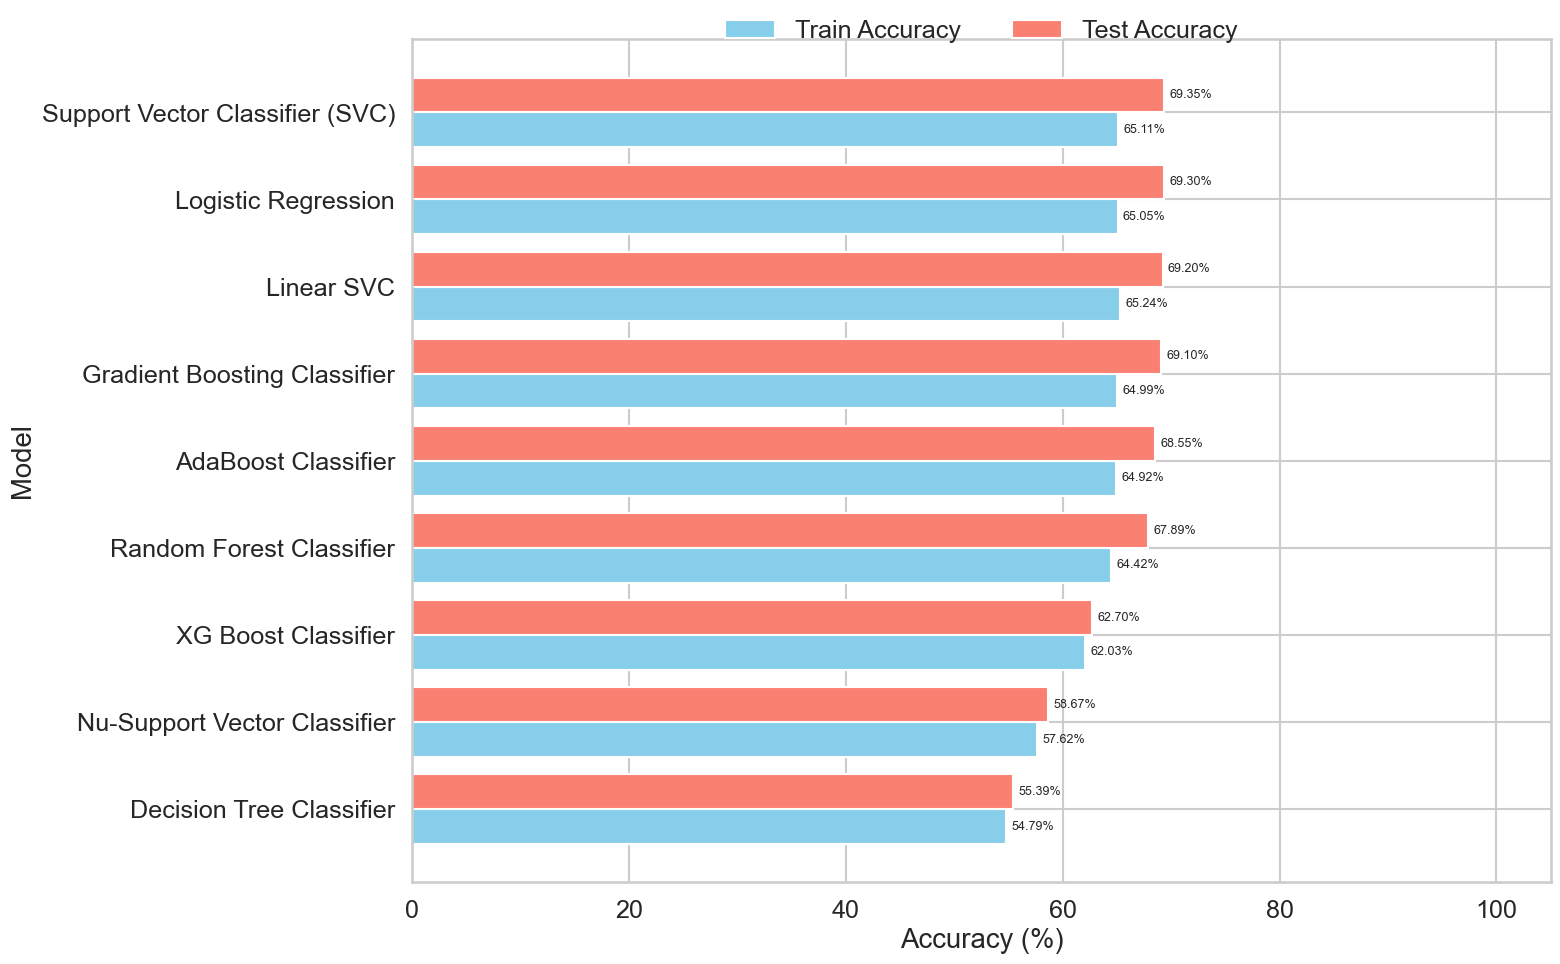

In [36]:
x=df.drop(['combined_condition'],axis=1)
y=df['combined_condition']


x_train_init,x_test,y_train_init,y_test=train_test_split(x,y,test_size=0.2,random_state=random_state)
x_train,x_val,y_train,y_val=train_test_split(x_train_init,y_train_init,test_size=0.2,random_state=random_state)
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)
x_val=ss.transform(x_val)

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

metrics0 = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = model.predict(x_val)
    acc0 = accuracy_score(y_val, y_pred0)
    f10 = f1_score(y_val, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_val, y_pred0, average='weighted')
    precision0 = precision_score(y_val, y_pred0, average='weighted')

    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc * 100)
    metrics['Precision'].append(precision * 100)
    metrics['Recall'].append(recall * 100)
    metrics['F1 Score'].append(f1 * 100)
    
    metrics0['Model'].append(name)
    metrics0['Accuracy'].append(acc0 * 100)
    metrics0['Precision'].append(precision0 * 100)
    metrics0['Recall'].append(recall0 * 100)
    metrics0['F1 Score'].append(f10 * 100)

    print(f"Model: {name}")
    print(f"Accuracy: {acc * 100:.2f}%, {acc0 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%, {precision0 * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%, {recall0 * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%, {f10 * 100:.2f}%")
    print("-" * 30)
    

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics0 = pd.DataFrame(metrics0)

# Merge train and test metrics for plotting
df_plot = df_metrics.merge(df_metrics0, on="Model", suffixes=("_Test", "_Train"))

# Sort by test accuracy
df_plot = df_plot.sort_values(by="Accuracy_Test", ascending=True).reset_index(drop=True)


# Set up the plot
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Bar positions
y_pos = range(len(df_plot))
bar_width = 0.4

# Plot train accuracy (shifted left)
plt.barh(
    [i - bar_width/2 for i in y_pos],
    df_plot["Accuracy_Train"],
    height=bar_width,
    label="Train Accuracy",
    color="skyblue"
)

# Plot test accuracy (shifted right)
plt.barh(
    [i + bar_width/2 for i in y_pos],
    df_plot["Accuracy_Test"],
    height=bar_width,
    label="Test Accuracy",
    color="salmon"
)

# Y-axis labels
plt.yticks(y_pos, df_plot["Model"])

# Add values to bars
for i, (train_acc, test_acc) in enumerate(zip(df_plot["Accuracy_Train"], df_plot["Accuracy_Test"])):
    plt.text(train_acc + 0.5, i - bar_width/2, f"{train_acc:.2f}%", va="center", fontsize=9)
    plt.text(test_acc + 0.5, i + bar_width/2, f"{test_acc:.2f}%", va="center", fontsize=9)

# Labels and title
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
#plt.title("Model Performance: Train vs Test Accuracy", fontsize=14)
plt.xlim(0, 105)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.show()